In [1]:
!pip install git+https://github.com/artemmavrin/focal-loss.git

  Cloning https://github.com/artemmavrin/focal-loss.git to /tmp/pip-req-build-q4i0ri6x
  Running command git clone -q https://github.com/artemmavrin/focal-loss.git /tmp/pip-req-build-q4i0ri6x
  Resolved https://github.com/artemmavrin/focal-loss.git to commit 7a1810a968051b6acfedf2052123eb76ba3128c4
  Created wheel for focal-loss: filename=focal_loss-0.0.8-py3-none-any.whl size=19050 sha256=f650c63a60e34f5cd55b9b617ece6c970182cf208e158571ecba0ba521cbbdfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-xirmsmnv/wheels/a2/9b/0f/a4d351aeb42d31330a290569400d5ff7bb54938658a508e9cd
Successfully built focal-loss
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
ERROR: pip's dependency resolver does 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from warnings import filterwarnings
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer, LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold

filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

In [3]:
from focal_loss import SparseCategoricalFocalLoss
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Input, Concatenate, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa

In [4]:
def plot_keras_history(history, measures):
    """
    history: Keras training history
    measures = list of names of measures
    """
    rows = len(measures) // 2 + len(measures) % 2
    fig, panels = plt.subplots(rows, 2, figsize=(15, 5))
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
    try:
        panels = [item for sublist in panels for item in sublist]
    except:
        pass
    for k, measure in enumerate(measures):
        panel = panels[k]
        panel.set_title(measure + ' history')
        panel.plot(history.epoch, history.history[measure], label="Train "+measure)
        panel.plot(history.epoch, history.history["val_"+measure], label="Validation "+measure)
        panel.set(xlabel='epochs', ylabel=measure)
        panel.legend()
        
    plt.show(fig)

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
train = pd.read_csv("../input/tabular-playground-series-dec-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-dec-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-dec-2021/sample_submission.csv")

In [7]:
# source: https://www.kaggle.com/remekkinas/tps-12-nn-tpu-pseudolabeling-0-95661
pseudolabels = pd.read_csv("../input/tps12-pseudolabels/tps12-pseudolabels_v2.csv")

In [8]:
print("The target class distribution:")
print((train.groupby('Cover_Type').Id.nunique() / len(train)).apply(lambda p: f"{p:.3%}"))

The target class distribution:
Cover_Type
1    36.703%
2    56.552%
3     4.893%
4     0.009%
5     0.000%
6     0.286%
7     1.557%
Name: Id, dtype: object


In [9]:
# Droping Cover_Type 5 label, since there is only one instance of it
train = train[train.Cover_Type != 5]

In [10]:
# remove unuseful features
train = train.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1)
pseudolabels = pseudolabels.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1)
test = test.drop(['Soil_Type7', 'Soil_Type15'], axis=1)

# extra feature engineering
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

def fe(df):
    df['EHiElv'] = df['Horizontal_Distance_To_Roadways'] * df['Elevation']
    df['EViElv'] = df['Vertical_Distance_To_Hydrology'] * df['Elevation']
    df['Aspect2'] = df.Aspect.map(r)
    ### source: https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/293373
    df["Aspect"][df["Aspect"] < 0] += 360
    df["Aspect"][df["Aspect"] > 359] -= 360
    df.loc[df["Hillshade_9am"] < 0, "Hillshade_9am"] = 0
    df.loc[df["Hillshade_Noon"] < 0, "Hillshade_Noon"] = 0
    df.loc[df["Hillshade_3pm"] < 0, "Hillshade_3pm"] = 0
    df.loc[df["Hillshade_9am"] > 255, "Hillshade_9am"] = 255
    df.loc[df["Hillshade_Noon"] > 255, "Hillshade_Noon"] = 255
    df.loc[df["Hillshade_3pm"] > 255, "Hillshade_3pm"] = 255
    ########
    df['Highwater'] = (df.Vertical_Distance_To_Hydrology < 0).astype(int)
    df['EVDtH'] = df.Elevation - df.Vertical_Distance_To_Hydrology
    df['EHDtH'] = df.Elevation - df.Horizontal_Distance_To_Hydrology * 0.2
    df['Euclidean_Distance_to_Hydrolody'] = (df['Horizontal_Distance_To_Hydrology']**2 + df['Vertical_Distance_To_Hydrology']**2)**0.5
    df['Manhattan_Distance_to_Hydrolody'] = df['Horizontal_Distance_To_Hydrology'] + df['Vertical_Distance_To_Hydrology']
    df['Hydro_Fire_1'] = df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Fire_Points']
    df['Hydro_Fire_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Fire_Points'])
    df['Hydro_Road_1'] = abs(df['Horizontal_Distance_To_Hydrology'] + df['Horizontal_Distance_To_Roadways'])
    df['Hydro_Road_2'] = abs(df['Horizontal_Distance_To_Hydrology'] - df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_1'] = abs(df['Horizontal_Distance_To_Fire_Points'] + df['Horizontal_Distance_To_Roadways'])
    df['Fire_Road_2'] = abs(df['Horizontal_Distance_To_Fire_Points'] - df['Horizontal_Distance_To_Roadways'])
    df['Hillshade_3pm_is_zero'] = (df.Hillshade_3pm == 0).astype(int)
    return df

train = fe(train)
test = fe(test)
pseudolabels = fe(pseudolabels)

# Summed features pointed out by @craigmthomas (https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/292823)
soil_features = [x for x in train.columns if x.startswith("Soil_Type")]
wilderness_features = [x for x in train.columns if x.startswith("Wilderness_Area")]

train["soil_type_count"] = train[soil_features].sum(axis=1)
pseudolabels["soil_type_count"] = pseudolabels[soil_features].sum(axis=1)
test["soil_type_count"] = test[soil_features].sum(axis=1)

train["wilderness_area_count"] = train[wilderness_features].sum(axis=1)
pseudolabels["wilderness_area_count"] = pseudolabels[wilderness_features].sum(axis=1)
test["wilderness_area_count"] = test[wilderness_features].sum(axis=1)

In [11]:
train = reduce_mem_usage(train)
pseudolabels = reduce_mem_usage(pseudolabels)
original_len = len(train)
train = pd.concat([train, pseudolabels], axis=0)

Mem. usage decreased to 556.25 Mb (76.1% reduction)
Mem. usage decreased to 97.67 Mb (81.7% reduction)


In [12]:
train

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Manhattan_Distance_to_Hydrolody,Hydro_Fire_1,Hydro_Fire_2,Hydro_Road_1,Hydro_Road_2,Fire_Road_1,Fire_Road_2,Hillshade_3pm_is_zero,soil_type_count,wilderness_area_count
0,0,3189,40,8,30,13,3270,206,234,193,...,43,4903,4843,3300,3240,8143,1603,0,1,1
1,1,3026,182,5,280,29,3270,233,240,106,...,309,5703,5143,3550,2990,8693,2153,0,1,1
2,2,3106,13,7,351,37,2914,208,234,137,...,388,5620,4918,3265,2563,8183,2355,0,1,1
3,3,3022,276,13,192,16,3034,207,238,156,...,208,3058,2674,3226,2842,5900,168,0,1,1
4,4,2906,186,13,266,22,2916,231,231,154,...,288,2908,2376,3182,2650,5558,274,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984706,4999995,2974,254,15,146,100,623,222,245,117,...,246,2499,2207,769,477,2976,1730,0,1,0
984707,4999996,3180,92,16,93,47,3740,209,201,142,...,140,449,263,3833,3647,4096,3384,0,1,0
984708,4999997,2684,51,20,34,123,962,199,225,145,...,157,384,316,996,928,1312,612,0,3,1
984709,4999998,3309,64,12,196,93,2522,226,193,74,...,289,3496,3104,2718,2326,5822,778,0,0,2


In [13]:
y = train.Cover_Type.values - 1
X = train.drop("Cover_Type", axis=1).set_index("Id").values.astype(np.float32)
Xt = test.set_index("Id").values.astype(np.float32)

In [14]:
X

array([[3.189e+03, 4.000e+01, 8.000e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       [3.026e+03, 1.820e+02, 5.000e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       [3.106e+03, 1.300e+01, 7.000e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       ...,
       [2.684e+03, 5.100e+01, 2.000e+01, ..., 0.000e+00, 3.000e+00,
        1.000e+00],
       [3.309e+03, 6.400e+01, 1.200e+01, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       [2.543e+03, 3.220e+02, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00]], dtype=float32)

In [15]:
Xt

array([[2.763e+03, 7.800e+01, 2.000e+01, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [2.826e+03, 1.530e+02, 1.100e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.948e+03, 5.700e+01, 1.900e+01, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [2.684e+03, 5.100e+01, 2.000e+01, ..., 0.000e+00, 3.000e+00,
        1.000e+00],
       [3.309e+03, 6.400e+01, 1.200e+01, ..., 0.000e+00, 0.000e+00,
        2.000e+00],
       [2.543e+03, 3.220e+02, 7.000e+00, ..., 0.000e+00, 0.000e+00,
        1.000e+00]], dtype=float32)

In [16]:
y

array([0, 1, 0, ..., 1, 0, 2], dtype=int8)

In [17]:
import gc
del([train, test, pseudolabels])
_ = [gc.collect() for i in range(5)]

In [18]:
y

array([0, 1, 0, ..., 1, 0, 2], dtype=int8)

In [19]:
le = LabelEncoder()
target = le.fit_transform(y)

_, classes_num = np.unique(target, return_counts=True)

In [20]:
y

array([0, 1, 0, ..., 1, 0, 2], dtype=int8)

In [21]:
### create baseline-model
def get_model(layers=[8], targets=7, dropout_rate=0.0, skip_layers=True, 
              batchnorm=True, activation='selu', kernel_initializer="lecun_normal"):
    
    inputs_sequence = Input(shape=(X.shape[1]))
    x = Flatten()(inputs_sequence)

    skips = list()
    for layer, nodes in enumerate(layers):
        x = Dense(nodes, kernel_initializer=kernel_initializer, activation=activation)(x)
        if batchnorm is True:
            x = BatchNormalization()(x)
        if layer != (len(layers) - 1):
            if dropout_rate > 0:
                x = Dropout(rate=dropout_rate)(x)
            skips.append(x)
    
    if skip_layers is True:
        x = Concatenate(axis=1)([x] + skips)
    else:
        del(skips)
        
    output_class = Dense(targets, activation='softmax', 
                         kernel_regularizer=tf.keras.regularizers.l2(l2=0.03))(x)

    model = Model(inputs=inputs_sequence, outputs=output_class)
    
    return model

In [22]:
dnn_params = {'layers': [128, 64, 64, 64], 
              'batchnorm': True, 
              'skip_layers': True, 
              'targets': len(le.classes_)}

model = get_model(**dnn_params)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 69)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 69)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          8960        flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128)          512         dense[0][0]                      
______________________________________________________________________________________________

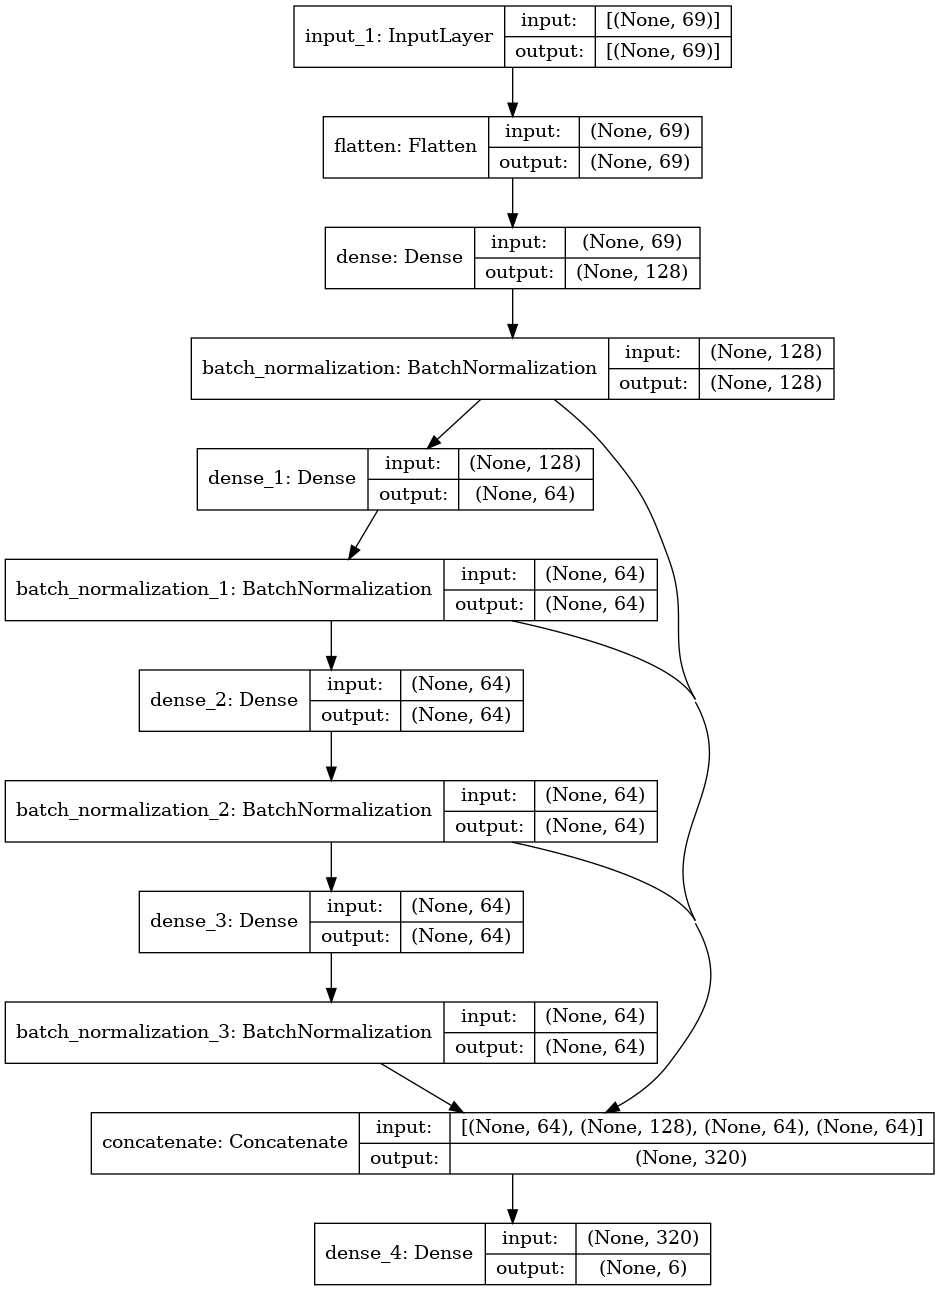

In [23]:
plot_model(
    model, 
    to_file='baseline.png', 
    show_shapes=True,
    show_layer_names=True
)

In [24]:
try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    # instantiate a distribution strategy
    tf_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("Running on TPU:", tpu.master())
except:
    tf_strategy = tf.distribute.get_strategy()
    print(f"Running on {tf_strategy.num_replicas_in_sync} replicas")
    print("Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Running on 1 replicas
Number of GPUs Available:  1


In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### define callbacks
early_stopping = EarlyStopping(
    monitor='val_acc', 
    min_delta=0, 
    patience=10, 
    verbose=0,
    mode='max', 
    baseline=None, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_acc', 
    factor=0.5,
    patience=5,
    mode='max'
)

****************************************
Fold 1 || Training
****************************************


2022-03-07 08:24:36.323487: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289793540 exceeds 10% of free system memory.
2022-03-07 08:24:37.639661: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289793540 exceeds 10% of free system memory.


Epoch 1/150
2282/2282 [==============================] - 15s 6ms/step - loss: 0.1954 - acc: 0.9454 - val_loss: 0.1340 - val_acc: 0.9522
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1141 - acc: 0.9588 - val_loss: 0.1138 - val_acc: 0.9559
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1031 - acc: 0.9606 - val_loss: 0.1104 - val_acc: 0.9559
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0970 - acc: 0.9619 - val_loss: 0.0989 - val_acc: 0.9593
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0931 - acc: 0.9628 - val_loss: 0.0986 - val_acc: 0.9589
Epoch 6/150
2282/2282 [==============================] - 13s 6ms/step - loss: 0.0905 - acc: 0.9634 - val_loss: 0.0955 - val_acc: 0.9593
Epoch 7/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0882 - acc: 0.9640 - val_loss: 0.0926 - val_acc: 0.9599
Epoch 8/150
2282/2282 [=========================

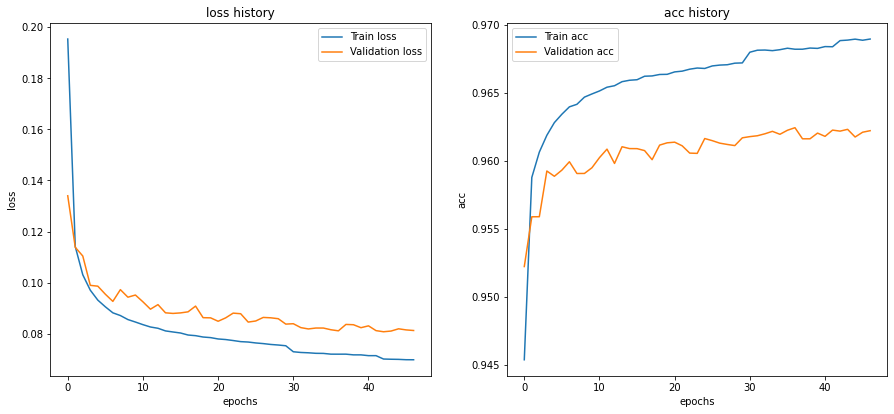

Best training accuracy: 0.96895
Best validation accuracy: 0.96244
****************************************
Fold 2 || Training
****************************************


2022-03-07 08:35:23.541748: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289793540 exceeds 10% of free system memory.
2022-03-07 08:35:24.882478: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289793540 exceeds 10% of free system memory.


Epoch 1/150
2282/2282 [==============================] - 14s 6ms/step - loss: 0.1978 - acc: 0.9454 - val_loss: 0.1331 - val_acc: 0.9526
Epoch 2/150
2282/2282 [==============================] - 13s 6ms/step - loss: 0.1153 - acc: 0.9586 - val_loss: 0.1169 - val_acc: 0.9551
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1033 - acc: 0.9607 - val_loss: 0.1137 - val_acc: 0.9549
Epoch 4/150
2282/2282 [==============================] - 14s 6ms/step - loss: 0.0967 - acc: 0.9621 - val_loss: 0.1014 - val_acc: 0.9583
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0928 - acc: 0.9629 - val_loss: 0.1012 - val_acc: 0.9580
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0898 - acc: 0.9637 - val_loss: 0.0946 - val_acc: 0.9597
Epoch 7/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0881 - acc: 0.9640 - val_loss: 0.0941 - val_acc: 0.9599
Epoch 8/150
2282/2282 [=========================

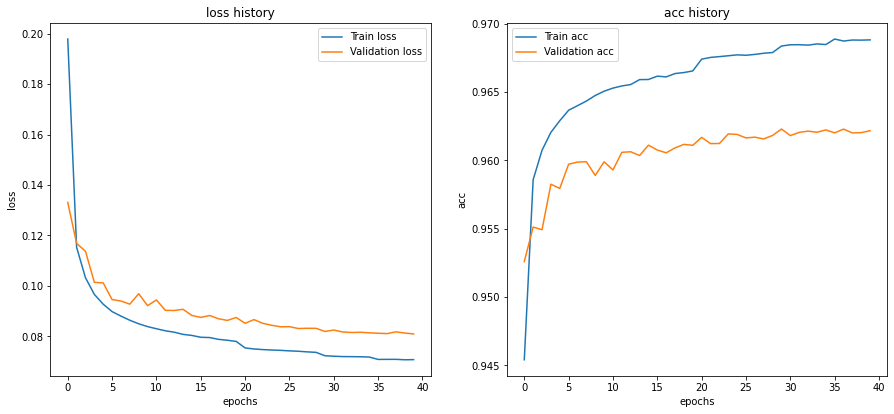

Best training accuracy: 0.96888
Best validation accuracy: 0.96230
****************************************
Fold 3 || Training
****************************************


2022-03-07 08:44:09.170937: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1289793540 exceeds 10% of free system memory.


Epoch 1/150
2282/2282 [==============================] - 16s 6ms/step - loss: 0.1933 - acc: 0.9460 - val_loss: 0.1348 - val_acc: 0.9528
Epoch 2/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1143 - acc: 0.9587 - val_loss: 0.1119 - val_acc: 0.9568
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1024 - acc: 0.9608 - val_loss: 0.1128 - val_acc: 0.9554
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0960 - acc: 0.9621 - val_loss: 0.1101 - val_acc: 0.9557
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0925 - acc: 0.9629 - val_loss: 0.0989 - val_acc: 0.9585
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0896 - acc: 0.9635 - val_loss: 0.1007 - val_acc: 0.9578
Epoch 7/150
2282/2282 [==============================] - 16s 7ms/step - loss: 0.0878 - acc: 0.9640 - val_loss: 0.0931 - val_acc: 0.9600
Epoch 8/150
2282/2282 [=========================

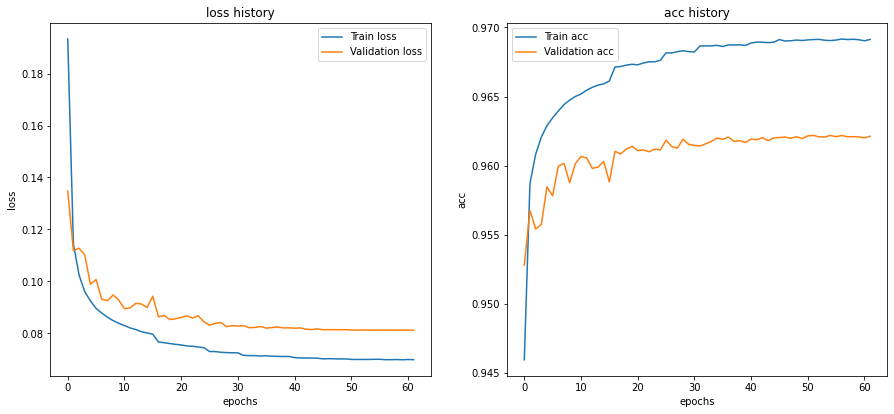

Best training accuracy: 0.96916
Best validation accuracy: 0.96219
****************************************
Fold 4 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1899 - acc: 0.9466 - val_loss: 0.1293 - val_acc: 0.9540
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1153 - acc: 0.9584 - val_loss: 0.1188 - val_acc: 0.9550
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1037 - acc: 0.9604 - val_loss: 0.1084 - val_acc: 0.9569
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0974 - acc: 0.9618 - val_loss: 0.1084 - val_acc: 0.9564
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0936 - acc: 0.9626 - val_loss: 0.1009 - val_acc: 0.9584
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0909 - acc: 0.9632 - val_loss: 0.0972 - val_acc: 0.9592
Epoch 7/150
2282/

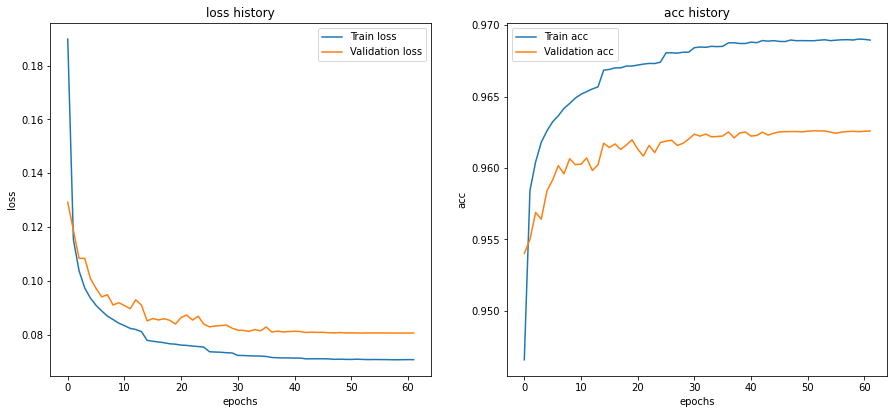

Best training accuracy: 0.96903
Best validation accuracy: 0.96261
****************************************
Fold 5 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 17s 7ms/step - loss: 0.1932 - acc: 0.9461 - val_loss: 0.1334 - val_acc: 0.9524
Epoch 2/150
2282/2282 [==============================] - 16s 7ms/step - loss: 0.1146 - acc: 0.9586 - val_loss: 0.1160 - val_acc: 0.9558
Epoch 3/150
2282/2282 [==============================] - 13s 6ms/step - loss: 0.1028 - acc: 0.9607 - val_loss: 0.1081 - val_acc: 0.9562
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0965 - acc: 0.9620 - val_loss: 0.1014 - val_acc: 0.9582
Epoch 5/150
2282/2282 [==============================] - 11s 5ms/step - loss: 0.0926 - acc: 0.9629 - val_loss: 0.0974 - val_acc: 0.9592
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0896 - acc: 0.9636 - val_loss: 0.0957 - val_acc: 0.9596
Epoch 7/150
2282/

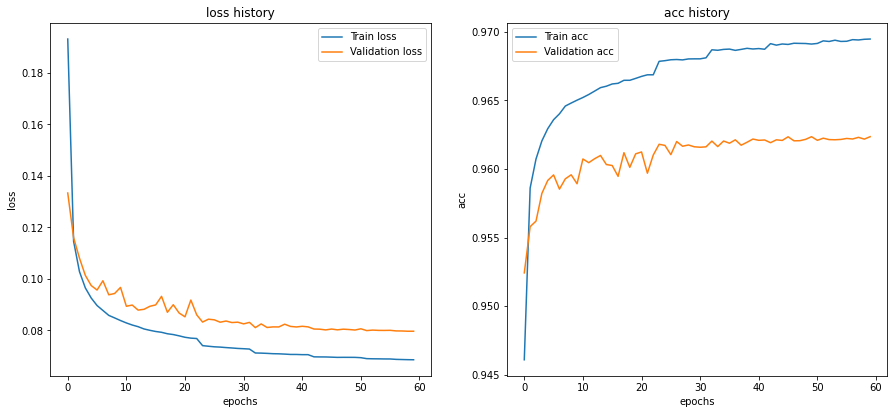

Best training accuracy: 0.96947
Best validation accuracy: 0.96236
****************************************
Fold 6 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1897 - acc: 0.9467 - val_loss: 0.1356 - val_acc: 0.9511
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1133 - acc: 0.9588 - val_loss: 0.1099 - val_acc: 0.9573
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1026 - acc: 0.9607 - val_loss: 0.1037 - val_acc: 0.9581
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0964 - acc: 0.9621 - val_loss: 0.1014 - val_acc: 0.9581
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0927 - acc: 0.9630 - val_loss: 0.0992 - val_acc: 0.9591
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0898 - acc: 0.9637 - val_loss: 0.0949 - val_acc: 0.9596
Epoch 7/150
2282/

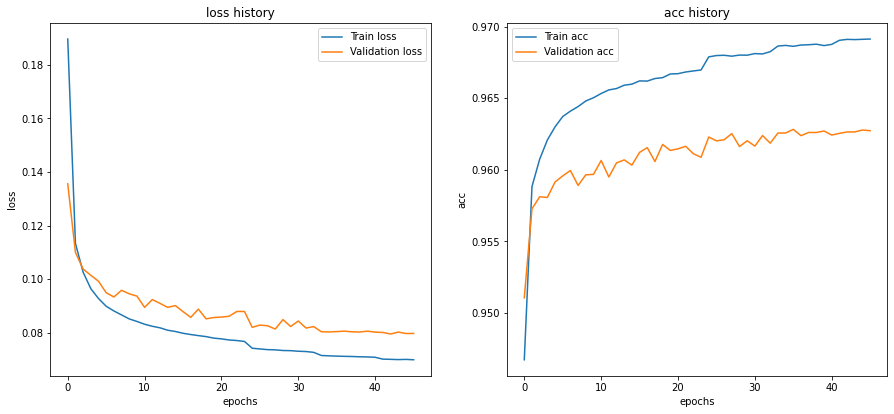

Best training accuracy: 0.96913
Best validation accuracy: 0.96282
****************************************
Fold 7 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1915 - acc: 0.9465 - val_loss: 0.1329 - val_acc: 0.9528
Epoch 2/150
2282/2282 [==============================] - 13s 6ms/step - loss: 0.1146 - acc: 0.9588 - val_loss: 0.1164 - val_acc: 0.9556
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1029 - acc: 0.9608 - val_loss: 0.1094 - val_acc: 0.9563
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0965 - acc: 0.9621 - val_loss: 0.1018 - val_acc: 0.9585
Epoch 5/150
2282/2282 [==============================] - 13s 6ms/step - loss: 0.0927 - acc: 0.9629 - val_loss: 0.0993 - val_acc: 0.9583
Epoch 6/150
2282/2282 [==============================] - 17s 7ms/step - loss: 0.0904 - acc: 0.9634 - val_loss: 0.0962 - val_acc: 0.9588
Epoch 7/150
2282/

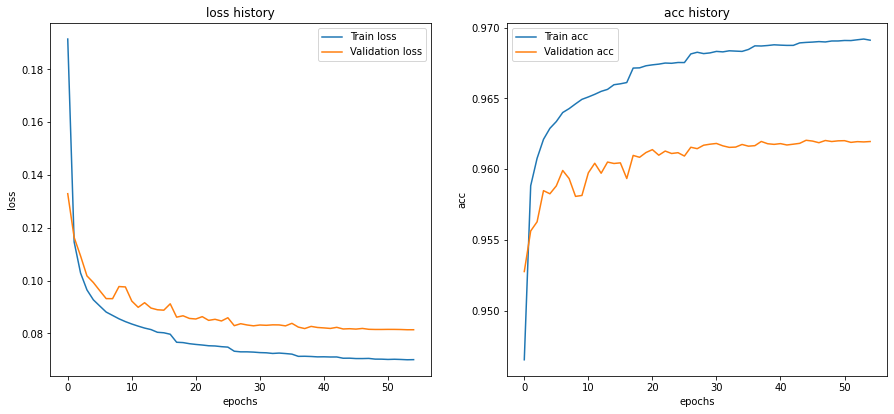

Best training accuracy: 0.96919
Best validation accuracy: 0.96204
****************************************
Fold 8 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1891 - acc: 0.9466 - val_loss: 0.1306 - val_acc: 0.9530
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1145 - acc: 0.9586 - val_loss: 0.1117 - val_acc: 0.9573
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1032 - acc: 0.9605 - val_loss: 0.1078 - val_acc: 0.9573
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0969 - acc: 0.9618 - val_loss: 0.1046 - val_acc: 0.9576
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0933 - acc: 0.9626 - val_loss: 0.0981 - val_acc: 0.9596
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0904 - acc: 0.9634 - val_loss: 0.1036 - val_acc: 0.9575
Epoch 7/150
2282/

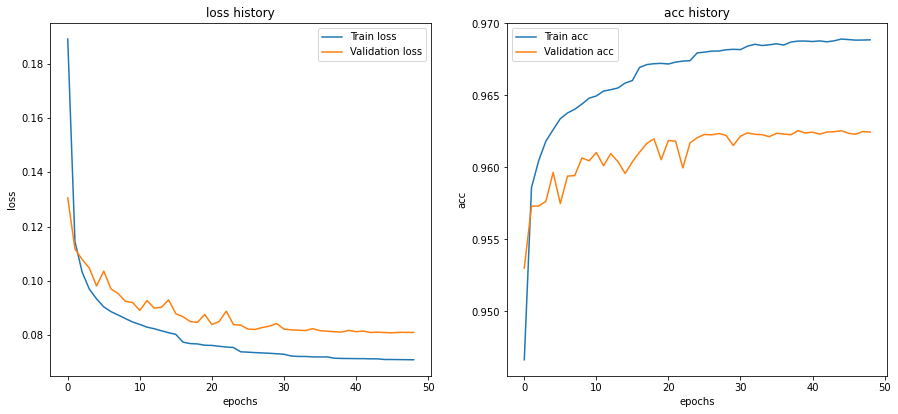

Best training accuracy: 0.96891
Best validation accuracy: 0.96255
****************************************
Fold 9 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 14s 5ms/step - loss: 0.1909 - acc: 0.9467 - val_loss: 0.1335 - val_acc: 0.9520
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1131 - acc: 0.9589 - val_loss: 0.1227 - val_acc: 0.9534
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1018 - acc: 0.9609 - val_loss: 0.1085 - val_acc: 0.9568
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0960 - acc: 0.9621 - val_loss: 0.1021 - val_acc: 0.9582
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0925 - acc: 0.9629 - val_loss: 0.0986 - val_acc: 0.9586
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0900 - acc: 0.9635 - val_loss: 0.0937 - val_acc: 0.9604
Epoch 7/150
2282/

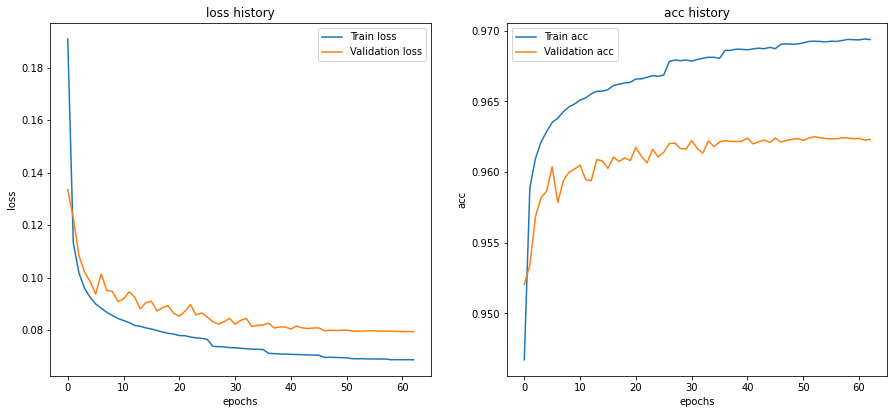

Best training accuracy: 0.96941
Best validation accuracy: 0.96250
****************************************
Fold 10 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 14s 5ms/step - loss: 0.1906 - acc: 0.9464 - val_loss: 0.1287 - val_acc: 0.9541
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1141 - acc: 0.9586 - val_loss: 0.1094 - val_acc: 0.9576
Epoch 3/150
2282/2282 [==============================] - 11s 5ms/step - loss: 0.1020 - acc: 0.9608 - val_loss: 0.1111 - val_acc: 0.9553
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0959 - acc: 0.9621 - val_loss: 0.0997 - val_acc: 0.9590
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0925 - acc: 0.9629 - val_loss: 0.0965 - val_acc: 0.9595
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0899 - acc: 0.9635 - val_loss: 0.0986 - val_acc: 0.9590
Epoch 7/150
2282

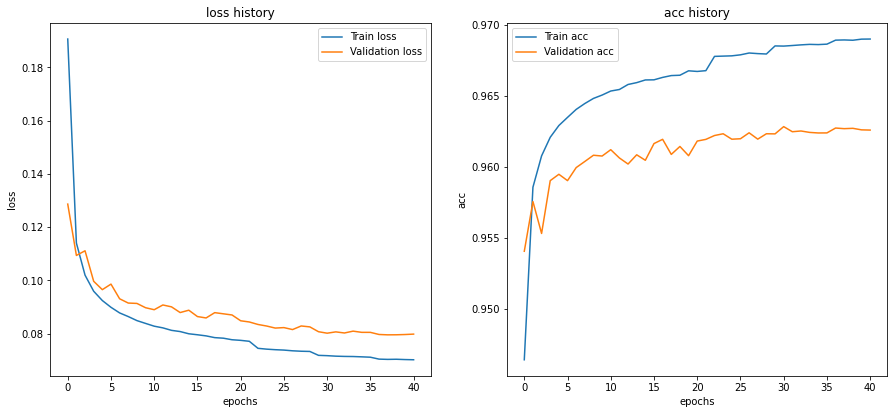

Best training accuracy: 0.96902
Best validation accuracy: 0.96284
****************************************
Fold 11 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1911 - acc: 0.9468 - val_loss: 0.1253 - val_acc: 0.9552
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1132 - acc: 0.9590 - val_loss: 0.1256 - val_acc: 0.9519
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1023 - acc: 0.9608 - val_loss: 0.1094 - val_acc: 0.9563
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0961 - acc: 0.9621 - val_loss: 0.0982 - val_acc: 0.9593
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0925 - acc: 0.9629 - val_loss: 0.0963 - val_acc: 0.9598
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0899 - acc: 0.9635 - val_loss: 0.0945 - val_acc: 0.9599
Epoch 7/150
2282

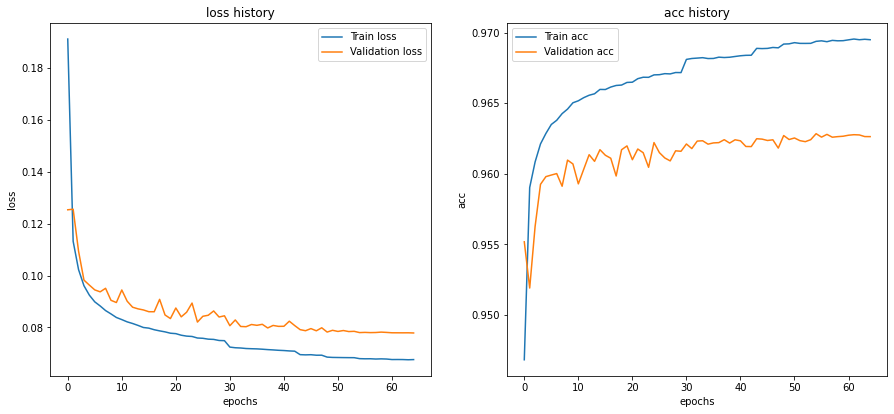

Best training accuracy: 0.96955
Best validation accuracy: 0.96284
****************************************
Fold 12 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1877 - acc: 0.9471 - val_loss: 0.1267 - val_acc: 0.9556
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1140 - acc: 0.9587 - val_loss: 0.1099 - val_acc: 0.9576
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1026 - acc: 0.9608 - val_loss: 0.1048 - val_acc: 0.9582
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0969 - acc: 0.9618 - val_loss: 0.0984 - val_acc: 0.9594
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0931 - acc: 0.9627 - val_loss: 0.0992 - val_acc: 0.9588
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0903 - acc: 0.9635 - val_loss: 0.0970 - val_acc: 0.9594
Epoch 7/150
2282

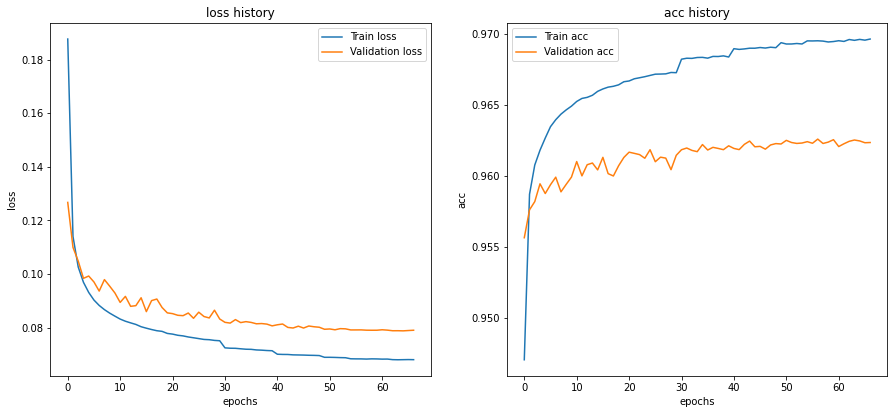

Best training accuracy: 0.96962
Best validation accuracy: 0.96258
****************************************
Fold 13 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1875 - acc: 0.9470 - val_loss: 0.1251 - val_acc: 0.9550
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1133 - acc: 0.9589 - val_loss: 0.1094 - val_acc: 0.9574
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1018 - acc: 0.9611 - val_loss: 0.1070 - val_acc: 0.9565
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0956 - acc: 0.9623 - val_loss: 0.1023 - val_acc: 0.9578
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0921 - acc: 0.9631 - val_loss: 0.1002 - val_acc: 0.9581
Epoch 6/150
2282/2282 [==============================] - 16s 7ms/step - loss: 0.0895 - acc: 0.9637 - val_loss: 0.0954 - val_acc: 0.9591
Epoch 7/150
2282

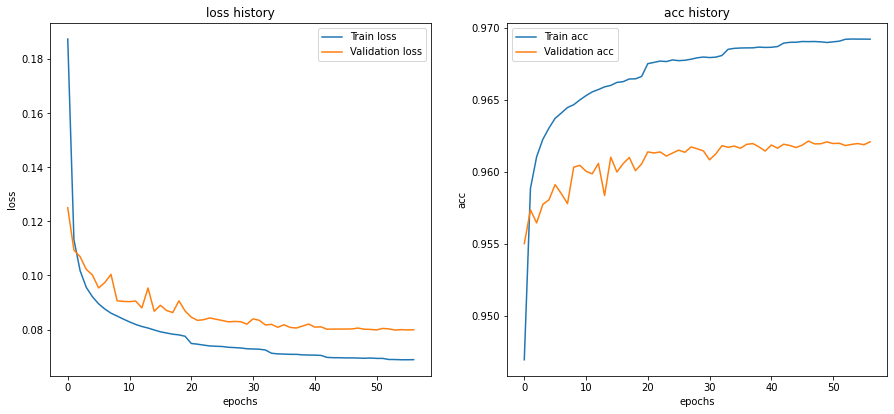

Best training accuracy: 0.96925
Best validation accuracy: 0.96216
****************************************
Fold 14 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1873 - acc: 0.9469 - val_loss: 0.1303 - val_acc: 0.9538
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1139 - acc: 0.9587 - val_loss: 0.1079 - val_acc: 0.9581
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1025 - acc: 0.9608 - val_loss: 0.1055 - val_acc: 0.9576
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0961 - acc: 0.9622 - val_loss: 0.0988 - val_acc: 0.9593
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0929 - acc: 0.9628 - val_loss: 0.0988 - val_acc: 0.9586
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0903 - acc: 0.9634 - val_loss: 0.0936 - val_acc: 0.9602
Epoch 7/150
2282

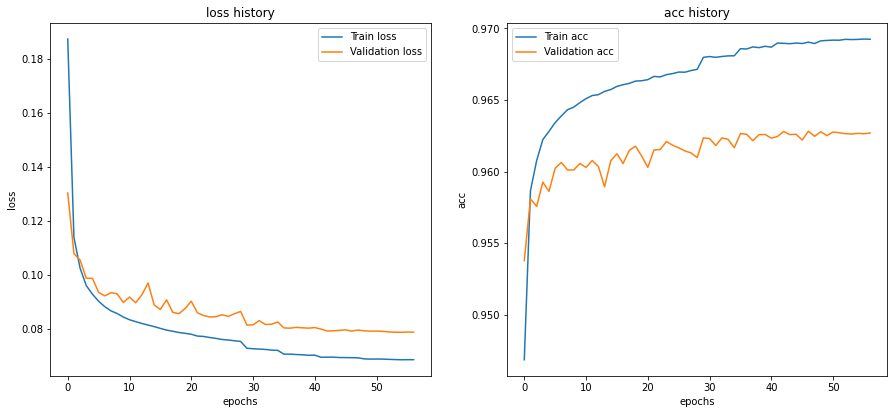

Best training accuracy: 0.96926
Best validation accuracy: 0.96282
****************************************
Fold 15 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 13s 5ms/step - loss: 0.1925 - acc: 0.9460 - val_loss: 0.1275 - val_acc: 0.9548
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1138 - acc: 0.9588 - val_loss: 0.1168 - val_acc: 0.9550
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1023 - acc: 0.9608 - val_loss: 0.1014 - val_acc: 0.9595
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0959 - acc: 0.9623 - val_loss: 0.1020 - val_acc: 0.9586
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0923 - acc: 0.9629 - val_loss: 0.1001 - val_acc: 0.9584
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0899 - acc: 0.9635 - val_loss: 0.0988 - val_acc: 0.9581
Epoch 7/150
2282

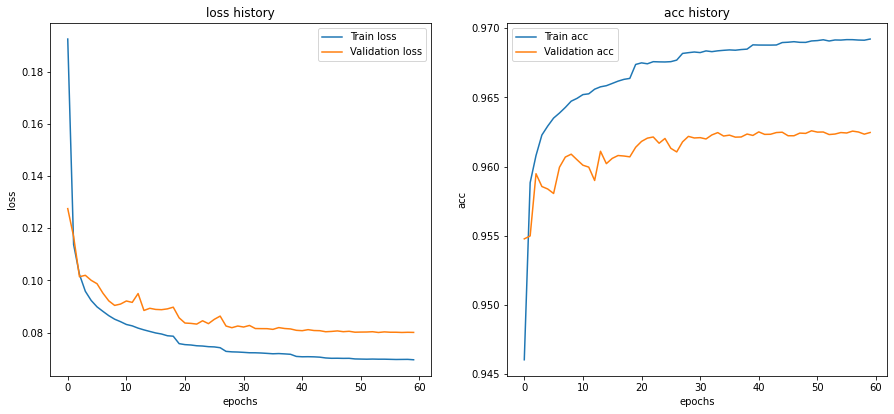

Best training accuracy: 0.96921
Best validation accuracy: 0.96258
****************************************
Fold 16 || Training
****************************************
Epoch 1/150
2282/2282 [==============================] - 14s 6ms/step - loss: 0.1895 - acc: 0.9465 - val_loss: 0.1318 - val_acc: 0.9527
Epoch 2/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1143 - acc: 0.9587 - val_loss: 0.1186 - val_acc: 0.9545
Epoch 3/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.1030 - acc: 0.9607 - val_loss: 0.1062 - val_acc: 0.9576
Epoch 4/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0967 - acc: 0.9620 - val_loss: 0.1016 - val_acc: 0.9581
Epoch 5/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0929 - acc: 0.9628 - val_loss: 0.0996 - val_acc: 0.9585
Epoch 6/150
2282/2282 [==============================] - 12s 5ms/step - loss: 0.0902 - acc: 0.9634 - val_loss: 0.1024 - val_acc: 0.9573
Epoch 7/150
2282

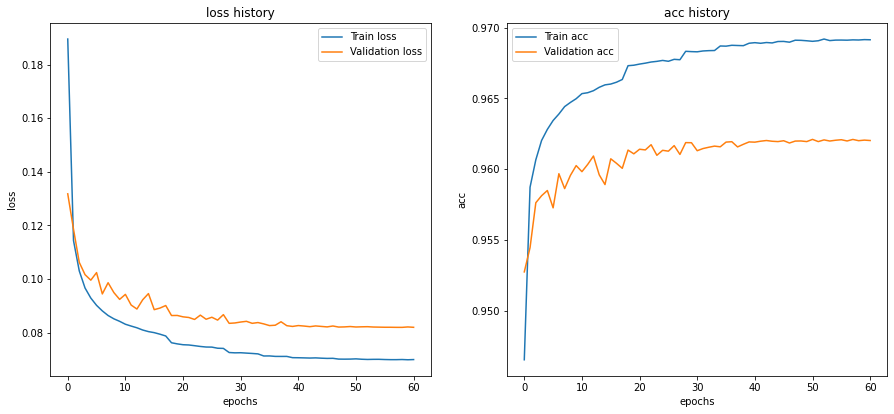

Best training accuracy: 0.96920
Best validation accuracy: 0.96211


In [26]:
N_FOLDS = 16

### cross-validation 
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=1)

predictions = np.zeros((len(Xt), len(le.classes_)))
oof = np.zeros((original_len, len(le.classes_)))
scores = list()

with tf_strategy.scope():
    for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
        
        idx_valid = idx_valid[idx_valid<original_len]
        X_train, y_train = X[idx_train, :], target[idx_train]
        X_valid, y_valid = X[idx_valid, :], target[idx_valid]
        
        ss = RobustScaler()
        X_train = ss.fit_transform(X_train)
        X_valid = ss.transform(X_valid)

        model = get_model(**dnn_params)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)    
    
        model.compile(
            optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(), #SparseCategoricalFocalLoss(gamma=2.), tf.keras.losses.SparseCategoricalCrossentropy()
            metrics=['acc']
        )

        print('**'*20)
        print(f"Fold {fold+1} || Training")
        print('**'*20)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_valid, y_valid),
            batch_size=1024*2,
            epochs=150,
            verbose=1,
            shuffle=True,
            callbacks=[
                early_stopping,
                reduce_lr
            ]
        )
        
        plot_keras_history(history, ['loss', 'acc'])
        
        print(f"Best training accuracy: {np.max(history.history['acc']):0.5f}")
        print(f"Best validation accuracy: {np.max(history.history['val_acc']):0.5f}")
        scores.append(np.max(history.history['val_acc']))

        oof[idx_valid] = model.predict(X_valid, batch_size=4096) 

        predictions += model.predict(ss.transform(Xt), batch_size=4096)
        
        del([X_train, y_train, X_valid, y_valid])
        gc.collect()

In [27]:
print(f"Average cv accuracy: {np.mean(scores):0.5f} (std={np.std(scores):0.5f})")

Average cv accuracy: 0.96248 (std=0.00026)


In [28]:
submission.Cover_Type = le.inverse_transform(np.argmax(predictions, axis=1)) + 1
submission.to_csv("submission.csv", index=False)

In [29]:
oof = pd.DataFrame(oof, columns=[f"prob_{i}" for i in le.classes_])
oof.insert(loc=0, column='Id', value=range(len(oof)))
oof.to_csv("oof.csv", index=False)